Part 1: Inpainting

Importing and dowloading libraries and datasets

In [1]:
import tensorflow as tf

In [5]:
import tensorflow_datasets as tfds
from tensorflow.keras import layers, optimizers, metrics, losses, Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import time
#import tensorflow_hub as hub

In [3]:
train_1 = tfds.load('imagenet_a')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating test examples...:   0%|          | 0/7500 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/imagenet_a/0.1.0.incompleteEWVWVO/imagenet_a-test.tfrecord*...:   0%|         …

Dataset imagenet_a downloaded and prepared to ~/tensorflow_datasets/imagenet_a/0.1.0. Subsequent calls will reuse this data.


In [4]:
#https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t12.tar.gz
#https://image-net.org/data/ILSVRC/2012/ILSVRC2012_devkit_t3.tar.gz
#import requests
#t = requests.get("http://www.image-net.org/challenges/LSVRC/2012/downloads", allow_redirects=True).text
#t = t.split("/ILSVRC2012_devkit_t12.tar.gz")[0].split('"')[-1]
#!sed -i 's/nonpub/{t}/g' tf-models/inception/inception/data/download_imagenet.sh 

Preprocessing datasets

In [5]:
train = tfds.load('imagenet_a', split = 'test[20%:100%]').map(lambda l: l['image'])
test = tfds.load('imagenet_a', split = 'test[0%:20%]').map(lambda l: l['image'])

In [6]:
train = train.map(lambda l: tf.cast(tf.image.resize_with_pad(l,128,128), tf.float64))
test = test.map(lambda l: tf.cast(tf.image.resize_with_pad(l,128,128),tf.float64))

In [7]:
train = train.map(lambda l: l/255)
test = test.map(lambda l: l/255)

In [8]:
it = iter(train)

In [9]:
sample_image = it.next()

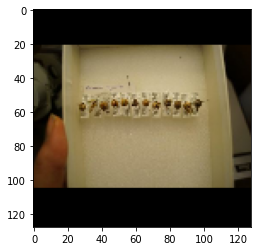

In [10]:
plt.imshow(sample_image)

Making the denoiser

In [12]:
u_inp = layers.Input(shape=(128,128,3), dtype = tf.float64)

In [13]:
#make the encoder and the decoder. Decoder can be downloaded and fine tuned.
#I have tried with a decoder I found in a blog post and one I trained myself

In [14]:
enc_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(u_inp)
enc_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(enc_x)
enc_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(enc_x)
enc_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(enc_x)
enc_x = layers.MaxPool2D()(enc_x)
enc_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(enc_x)
enc_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(enc_x)
enc_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(enc_x)
enc_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(enc_x)
enc_x = layers.MaxPool2D()(enc_x)
enc_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(enc_x)
enc_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(enc_x)
enc_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(enc_x)
enc_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(enc_x)
enc_x = layers.MaxPool2D()(enc_x)
enc_x = layers.Conv2D(512,3, padding = 'same', dtype = tf.float64, activation = 'relu')(enc_x)


In [15]:
enc_x

<KerasTensor: shape=(None, 16, 16, 512) dtype=float64 (created by layer 'conv2d_6')>

In [16]:
encoder = Model(inputs=u_inp, outputs=enc_x)

In [17]:
dec_input = layers.Input(shape=(8,8,1024), dtype = tf.float64)

In [18]:

dec_x = layers.Conv2D(512,3, padding = 'same', dtype = tf.float64, activation = 'relu')(dec_input)
dec_x = layers.Conv2DTranspose(256,(2,2), strides = (2,2))(dec_x)
dec_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(dec_x)
dec_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(dec_x)
dec_x = layers.Conv2DTranspose(128,(2,2), strides = (2,2))(dec_x)
dec_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(dec_x)
dec_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(dec_x)
dec_x = layers.Conv2DTranspose(16,(2,2), strides = (2,2))(dec_x)
dec_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(dec_x)
dec_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(dec_x)
dec_x = layers.Conv2D(3,3, padding = 'same', dtype = tf.float64)(dec_x)


In [19]:
dec_x

<KerasTensor: shape=(None, 64, 64, 3) dtype=float64 (created by layer 'conv2d_14')>

In [20]:
decoder = Model(inputs = dec_input, outputs = dec_x)

In [21]:
#to take the pre-trained model:
#decoder.load_weights("pretrained_checkpoint")

In [22]:
#This is not what was ultimately used, but is useful to have a notebook that can run by itself

aut_x = layers.Conv2D(512,3, padding = 'same', dtype = tf.float64, activation = 'relu')(enc_x)
aut_x = layers.Conv2DTranspose(256,(2,2), strides = (2,2))(aut_x)
aut_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(aut_x)
aut_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(aut_x)
aut_x = layers.Conv2DTranspose(32,(2,2), strides = (2,2))(aut_x)
aut_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(aut_x)
aut_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(aut_x)
aut_x = layers.Conv2DTranspose(16,(2,2), strides = (2,2))(aut_x)
aut_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(aut_x)
aut_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(aut_x)
aut_x = layers.Conv2D(3,3, padding = 'same', dtype = tf.float64)(aut_x)


In [23]:
aut_x

<KerasTensor: shape=(None, 128, 128, 3) dtype=float64 (created by layer 'conv2d_22')>

In [24]:
autoencoder = Model(inputs=u_inp, outputs=aut_x)

In [ ]:
#Setting up inpainting

In [25]:
#paper has T = 250 r = 10 j = 10
T = 251
step_variance = 0.15

In [26]:
#I don't think it's that important to speed this up. Also, it makes sense to always use the same schedule for the training. There is no reason to change the schedule at inference time
#Also, I need to have a 0 at timestep 0
schedule = [0.0]
for i in range (T):
  #schedule.append(random.uniform(25/255,30/255))
  schedule.append(step_variance)

In [27]:
square_schedule = []
for i in schedule:
  square_schedule.append(i**2)

In [28]:
#I will need the final standard deviation after each step. i.e. the stddev of the sum of the noises
prep_schedule = []
total = 0
for i in range(len(square_schedule)):
  total += square_schedule[i]
  prep_schedule.append(total)
for i in range(len(prep_schedule)):
  prep_schedule[i] = math.sqrt(prep_schedule[i])

In [29]:
def add_noise (image, schedule, t):
  noise = tf.random.normal(image.shape,stddev=prep_schedule[t], dtype=tf.float64)
  return image + noise

In [ ]:
#I don't think it's that important to speed this up. Also, it makes sense to always use the same schedule for the training. There is no reason to change the schedule at inference time
#Also, I need to have a 0 at timestep 0
schedule = [0.0]
for i in range (T):
  #schedule.append(random.uniform(25/255,30/255))
  schedule.append(step_variance)
square_schedule = []
for i in schedule:
  square_schedule.append(i**2)
prep_schedule = []
total = 0
for i in range(len(square_schedule)):
  total += square_schedule[i]
  prep_schedule.append(total)
for i in range(len(prep_schedule)):
  prep_schedule[i] = math.sqrt(prep_schedule[i])

In [32]:
def custom_train(x, mod, batch_size, optimizer):

    with tf.GradientTape() as tape:

      #to make a batch of noises woth differnet standard deviation, i can make a big tensor with stddev of 1, and then multiply each element for
      #its corresponding standard deviation
        random_t = tf.random.uniform([x.shape[0]],minval=1,maxval=250, dtype=tf.int32)
        float_random_t = tf.cast(random_t, tf.float64)
        stddevs = tf.map_fn(lambda l: prep_schedule[tf.cast(l,tf.int32)],float_random_t)

        actual_noises = tf.random.normal(x.shape, dtype=tf.float64)
        actual_noises = tf.transpose(tf.transpose(actual_noises)*stddevs)
        noisy_images = x+actual_noises
        predicted_noises = mod(noisy_images)
        
        loss = tf.keras.losses.MeanSquaredError()(actual_noises, predicted_noises)
        

    grads = tape.gradient(loss, mod.trainable_variables)

    optimizer.apply_gradients(zip(grads, mod.trainable_variables))

    return loss

In [33]:
n_epochs = 0
loss_history = []
epoch_loss_history = []
opt = tf.keras.optimizers.Adam()
batch_size = 32

In [35]:

for i in range(n_epochs):
  batch_count = 0
  start = time.time()
  for batch in train.shuffle(1000).batch(batch_size):
    loss_history.append(custom_train(batch,autoencoder,batch_size,opt))
    batch_count +=1
    if batch_count % 10 == 0:
      #print("\r", end = '', flush = True)
      print(batch_count)
    #print('')
  print(time.time()-start)
  np_history = np.asarray(loss_history)
  mean = np.mean(np_history)
  print(mean)
  epoch_loss_history.append(mean)
  loss_history = []

In [36]:
clear_sample = iter(test).next()

In [38]:
noisy_sample = add_noise(clear_sample,prep_schedule,0)

In [41]:
img = noisy_sample

In [43]:
#img = noisy_sample
#for i in range(250,0,-1):
#  last_noise = img-autoencoder(tf.reshape(noisy_sample,[1,128,128,3]))[0]
#  img = img-last_noise
#plt.imshow(img)

Inference

In [44]:
def stack_overflow_mask():
  mask = tf.concat([
      tf.zeros([img_size, y1]),
      tf.concat([tf.zeros([x1, y2-y1]), tf.ones([x2-x1, y2-y1]), tf.zeros([img_size - x2, y2-y1])], axis=0),
      tf.zeros([img_size, img_size - y2])
    ], axis=1)
  mask = tf.stack([mask] * channels, axis=2)

In [45]:
def generate_mask(image, y1, y2, x1, x2):
  #x and y are inverted wrt to how I would call them
  mask = tf.concat([
      tf.zeros([image.shape[0], y1]),
      tf.concat([tf.zeros([x1, y2-y1]), tf.ones([x2-x1, y2-y1]), tf.zeros([image.shape[0] - x2, y2-y1])], axis=0),
      tf.zeros([image.shape[0], image.shape[1] - y2])
    ], axis=1)
  mask = tf.stack([mask] * image.shape[-1], axis=2)
  return tf.cast(mask,tf.float64)

In [46]:
def generate_hole_mask(image, y1, y2, x1, x2):
  return 1 - generate_mask(image, y1, y2, x1, x2)

In [47]:
#tf.boolean_mask(img, mask)

In [48]:
alphas = []
for i in schedule:
  alphas.append(1-i)

In [49]:
square_alphas = []
for i in alphas:
  square_alphas.append(i**2)
square_alphas[0] = 0


In [50]:
prep_alphas = []
total = 0
for i in range(len(square_alphas)):
  total += square_alphas[i]
  prep_alphas.append(total)
for i in range(len(prep_alphas)):
  prep_alphas[i] = math.sqrt(prep_alphas[i])

In [51]:
#sample t-1 of known region
#tf.random.normal(mean = math.sqrt(alpha)*x_0, stddev = 1-alpha*tf.ones(x_0.shape))

In [52]:
def sample_known(image, t):
  t = t-1
  return tf.random.normal((1-prep_alphas[t])*tf.ones(image.shape), mean = math.sqrt(prep_alphas[t])*image )

In [53]:
def inpainting(image, denoiser, mask, T = 251, r = 10, j = 10): #
  noise_checker = 0 #
  noisy_image = image*mask
  noisy_image = add_noise(noisy_image, schedule, T)
  noise_checker += T#
  for i in range(T - j, 0, (-1)*j):
    
    for round in range(r):
      for step in range(j):
        total_noise = denoiser(tf.reshape(noisy_image,[1,128,128,3]))[0]
        fraction_of_noise = (1/(i+step+1))*(total_noise)
        noisy_image = noisy_image-fraction_of_noise
        total_denoising = noise_checker#
        fraction_denoising = (1/(i+step+1))*total_denoising#
        noise_checker -= fraction_denoising #
        #
        known_sample = image + tf.random.normal(image.shape, stddev = math.sqrt(noise_checker*(step_variance**2)), dtype = tf.float64)
        known_sample = known_sample*mask
        noisy_image = noisy_image * (1-mask)
        noisy_image = noisy_image + known_sample
      if round < (r-1):
        noisy_image = noisy_image + tf.random.normal(noisy_image.shape, stddev = (prep_schedule[i+j]-prep_schedule[i]), dtype = tf.float64)
        noise_checker += j#

  
  noisy_image = noisy_image - denoiser(tf.reshape(noisy_image,[1,128,128,3]))[0]
  final_image = (image*mask) + (noisy_image*(1-mask))
  return final_image

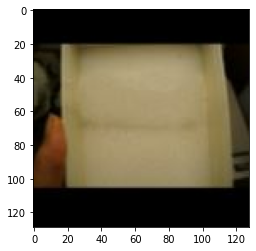

In [6]:
mask = generate_hole_mask(clear_sample, 50, 100, 50, 100)
inpainted_image = inpainting(sample_image, autoencoder, mask)
plt.imshow(inpainted_image)

In [55]:
#%pip install pyyaml h5py

In [56]:
#import os
#from tensorflow import keras
#autoencoder.save_weights('my_checkpoint')

Part 2: Hper-resolution

Hyper resolution with GANs

In [57]:
class InstanceNormalization(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    
    

  
  def call(self,inputs):
        return (inputs - tf.reduce_mean(inputs, axis = 0, keepdims = True))\
    /(tf.math.reduce_std(inputs, axis = 0, keepdims = True) + 1e-05)

In [58]:
class PositionalNormalization(tf.keras.layers.Layer):
  def __init__(self):
    super().__init__()
    
    

  
  def call(self,inputs):
        return (inputs - tf.reduce_mean(inputs, axis = 1, keepdims = True))\
    /(tf.math.reduce_std(inputs, axis = 1, keepdims = True) + 1e-05)

In [59]:
disc_input = layers.Input(shape=(256,256,3), dtype = tf.float64)

In [60]:
disc_x = layers.Conv2D(32,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_input)
disc_x = layers.Conv2D(32,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_x)
disc_x = layers.MaxPool2D()(disc_x)
disc_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_x)
disc_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_x)
disc_x = layers.Conv2D(1,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_x)
disc_x = layers.Flatten()(disc_x)
#disc_x = layers.Dense(16, activation = 'relu')(disc_x)
disc_x = layers.Dense(1, activation = 'sigmoid')(disc_x)

In [61]:
discriminator = Model(inputs=disc_input, outputs=disc_x)

In [62]:
class DownBlock(tf.keras.layers.Layer):
  def __init__(self, output_channels):
    super().__init__()
    self.output_channels = output_channels
    self.conv = layers.Conv2D(output_channels, 3, padding = 'same',\
    dtype = tf.float64, activation= layers.LeakyReLU(alpha=0.01))
    self.instance_norm = InstanceNormalization()
    self.pos_norm = PositionalNormalization()
  
  def call(self, inputs):
        out = self.instance_norm(inputs)
        out = self.conv(out)
        out = self.pos_norm(out)
        out = layers.AveragePooling2D(dtype = tf.float64)(out)
        return out

#instance normalization -> 2d conv -> posnorm -> avPool

In [63]:
class UpBlock(tf.keras.layers.Layer):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = layers.Conv2D(output_channels / 2, 3, padding = 'same',\
    dtype = tf.float64, activation= layers.LeakyReLU(alpha=0.01))
    self.transpose= layers.Conv2DTranspose(output_channels,(2,2), strides = (2,2),dtype = tf.float64)
  
  def call(self, high_res, previous_output, low_res):
        high_res = tf.cast(high_res, dtype = tf.float64)
        inp = tf.concat ((high_res, previous_output, low_res), axis = 3)
        out = self.conv(inp)
        out = self.transpose(out)
        return out

#instance normalization -> 2d conv -> posnorm -> avPool

In [64]:
class MidBlock(tf.keras.layers.Layer):
  def __init__(self, output_channels):
    super().__init__()
    self.conv = layers.Conv2D(output_channels / 2, 3, padding = 'same',\
    dtype = tf.float64, activation= layers.LeakyReLU(alpha=0.01))
  
  def call(self, high_res, previous_output, low_res):
        high_res = tf.cast(high_res, dtype = tf.float64)
        inp = tf.concat ((high_res, previous_output, low_res), axis = 3)
        out = self.conv(inp)
        return out


In [65]:
high_input = layers.Input(shape=(256,256,3), dtype = tf.float64)
low_input = layers.Input(shape=(128,128,3), dtype = tf.float64)

In [66]:
down_x_0 =layers.Conv2D(8,1, padding = 'same', dtype = tf.float64, activation = 'relu')(high_input)
down_x_1 = DownBlock(16)(down_x_0)#128
down_x_2=  DownBlock(32)(down_x_1)#64
#down_x_3=  DownBlock(512)(down_x_2)#32
low_res_0 = layers.Conv2DTranspose(8,(2,2), strides = (2,2), dtype = tf.float64)(low_input)
low_res_1 = layers.Conv2D(16,1, padding = 'same', dtype = tf.float64, activation = 'relu')(low_input)
low_res_2 = DownBlock(32)(low_res_1)#64
#low_res_3=  DownBlock(512)(low_res_2)#32
#up_x_3 = UpBlock(256)(down_x_3, down_x_3,low_res_3)#32, 32, 32
up_x_2 = UpBlock(16)(down_x_2, down_x_2,low_res_2)#64, 64, 64
up_x_1 = UpBlock(8)(down_x_1, up_x_2,low_res_1)#128,128,128
up_x_0 = MidBlock(4)(down_x_0, up_x_1,low_res_0)#256,256,256
final_x = layers.Conv2D(3,1, padding = 'same', dtype = tf.float64, activation = 'relu')(up_x_0)


In [67]:
generator = Model(inputs=(high_input, low_input), outputs=final_x)
c_lambda = 0.5

In [68]:
#train generator and discriminator
def GAN_train(x_high, x_low, gen, disc, batch_size, optimizer):
    with tf.GradientTape(persistent = True) as tape:
        
        #alternative version trains 1 epoch the generator, using loss_2, loss_3, 1 epoch the discriminator, using loss_1
        loss_1 = tf.keras.losses.BinaryCrossentropy()(disc(x_high),tf.zeros([batch_size,1], dtype = tf.float64))
        loss_2 = tf.keras.losses.BinaryCrossentropy()(disc(gen((x_high,x_low))), tf.ones([batch_size,1], dtype = tf.float64))
        loss_3 = tf.keras.losses.MeanSquaredError()\
        (x_high,\
         gen((gen((x_high, x_low)), tf.image.resize_with_pad(x_high,128,128))))
        total_loss = loss_1 + loss_2 + (c_lambda * loss_3)

    gen_grads = tape.gradient(total_loss, gen.trainable_variables)
    
    disc_grads = tape.gradient(total_loss, disc.trainable_variables)

    optimizer.apply_gradients(zip(gen_grads, gen.trainable_variables))
    optimizer.apply_gradients(zip(disc_grads, disc.trainable_variables))

    del tape

    return total_loss
    

In [ ]:
def GAN_train_alternate(x_high, x_low, gen, disc, batch_size, optimizer, epoch_n):
    total_loss = 0
    small_constant = 1e-3

    if epoch_n%3 == 0:
        with tf.GradientTape(persistent = True) as tape:

            #alternative version trains 1 epoch the generator, using loss_2, loss_3, 1 epoch the discriminator, using loss_1

            loss_1 = tf.keras.losses.BinaryCrossentropy()(disc(x_high),tf.zeros([batch_size,1], dtype = tf.float64))
            loss_2 = tf.keras.losses.BinaryCrossentropy()(disc(gen((x_high,x_low))), tf.ones([batch_size,1], dtype = tf.float64))
            loss_3 = tf.keras.losses.MeanSquaredError()\
            (x_high,\
             gen((gen((x_high, x_low)), tf.image.resize_with_pad(x_high,128,128))))
            total_loss = loss_1 + loss_2 + (c_lambda * loss_3)

        gen_grads = tape.gradient(total_loss, gen.trainable_variables)

        disc_grads = tape.gradient(total_loss, disc.trainable_variables)

        optimizer.apply_gradients(zip(gen_grads, gen.trainable_variables))
        optimizer.apply_gradients(zip(disc_grads, disc.trainable_variables))

        del tape
    else:
        with tf.GradientTape(persistent = True) as tape:


            loss_1 = tf.keras.losses.BinaryCrossentropy()(disc(x_high),tf.zeros([batch_size,1], dtype = tf.float64))
            loss_2 = tf.keras.losses.BinaryCrossentropy()(disc(gen((x_high,x_low))), tf.ones([batch_size,1], dtype = tf.float64))
            


        disc_grads = tape.gradient(total_loss, disc.trainable_variables)

        optimizer.apply_gradients(zip(gen_grads, gen.trainable_variables))
        optimizer.apply_gradients(zip(disc_grads, disc.trainable_variables))

        del tape
        

    return total_loss
    

In [69]:
train_high = tfds.load('imagenet_a', split = 'test[20%:100%]').map(lambda l: l['image'])
test_high = tfds.load('imagenet_a', split = 'test[0%:20%]').map(lambda l: l['image'])
train_high = train_high.map(lambda l: tf.cast(tf.image.resize_with_pad(l,256,256), tf.int32))
test_high = test_high.map(lambda l: tf.cast(tf.image.resize_with_pad(l,256,256),tf.int32))
train_high = train_high.map(lambda l: l/255)
test_high = test_high.map(lambda l: l/255)

In [85]:
n_epochs = 0
loss_history = []
epoch_loss_history = []
opt = tf.keras.optimizers.Adam()
batch_size = 8

In [97]:
train_high = train_high.shuffle(1000)
GAN_dataset = tf.data.Dataset.zip((train_high, train))

In [86]:
for i in range(n_epochs):
  batch_count = 0
  start = time.time()
  for batch in GAN_dataset.shuffle(1000).batch(batch_size):
    loss_history.append(GAN_train(batch[0], batch[1] ,generator, discriminator,batch_size,opt))
    batch_count +=1
    if batch_count % 10 == 0:
      #print("\r", end = '', flush = True)
      print(batch_count)
    #print('')
  print(time.time()-start)
  np_history = np.asarray(loss_history)
  mean = np.mean(np_history)
  print(mean)
  epoch_loss_history.append(mean)
  loss_history = []

In [102]:
low_res_image = sample_image
low_res_image = tf.reshape(low_res_image,[1,128,128,3])
high_res_image = iter(test_high).next()
high_res_image = tf.reshape(high_res_image,[1,256,256,3])

In [ ]:
#generator((high_res_image, low_res_image))[0]

Hyper resolution with diffusion

In [124]:
def diffusion_hyper_resolution(image, denoiser, T = 251, r = 10, j = 10): #
  noise_checker = 0 #
  noisy_image = image
  noisy_image = tf.image.resize_with_pad(noisy_image,256,256)
  noisy_image = tf.cast(noisy_image, tf.float64)
  noisy_image = add_noise(noisy_image, schedule, T)
  noise_checker += T#
  for i in range(T - j, 0, (-1)*j):
    
    for round in range(r):
      for step in range(j):
        total_noise = denoiser(tf.reshape(noisy_image,[1,256,256,3]))[0]
        fraction_of_noise = (1/(i+step+1))*(total_noise)
        noisy_image = noisy_image-fraction_of_noise
        total_denoising = noise_checker#
        fraction_denoising = (1/(i+step+1))*total_denoising#
        noise_checker -= fraction_denoising #
        #
      if round < (r-1):
        noisy_image = noisy_image + tf.random.normal(noisy_image.shape, stddev = (prep_schedule[i+j]-prep_schedule[i]), dtype = tf.float64)
        noise_checker += j#

  
  final_image = noisy_image - denoiser(tf.reshape(noisy_image,[1,256,256,3]))[0]
  return final_image

In [112]:
high_aut_inp = layers.Input(shape=(256,256,3), dtype = tf.float64)

In [113]:
high_aut_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_inp)
high_aut_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(high_aut_x)
high_aut_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(high_aut_x)
high_aut_x = layers.MaxPool2D()(high_aut_x)
high_aut_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(high_aut_x)
high_aut_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(high_aut_x)
high_aut_x = layers.MaxPool2D()(high_aut_x)
high_aut_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(high_aut_x)
high_aut_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.BatchNormalization(epsilon=1e-3, momentum=0.999)(high_aut_x)
high_aut_x = layers.MaxPool2D()(high_aut_x)
high_aut_x = layers.Conv2D(512,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.Conv2D(512,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.Conv2DTranspose(256,(2,2), strides = (2,2))(high_aut_x)
high_aut_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.Conv2D(256,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.Conv2DTranspose(32,(2,2), strides = (2,2))(high_aut_x)
high_aut_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.Conv2D(128,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.Conv2DTranspose(16,(2,2), strides = (2,2))(high_aut_x)
high_aut_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(high_aut_x)
high_aut_x = layers.Conv2D(3,3, padding = 'same', dtype = tf.float64)(high_aut_x)

In [116]:
autoencoder_high = Model(inputs = high_aut_inp, outputs = high_aut_x)

In [109]:
n_epochs = 0
loss_history = []
epoch_loss_history = []
opt = tf.keras.optimizers.Adam()
batch_size = 32

In [110]:

for i in range(n_epochs):
  batch_count = 0
  start = time.time()
  for batch in train_high.shuffle(1000).batch(batch_size):
    loss_history.append(custom_train(batch,autoencoder_high,batch_size,opt))
    batch_count +=1
    if batch_count % 10 == 0:
      #print("\r", end = '', flush = True)
      print(batch_count)
    #print('')
  print(time.time()-start)
  np_history = np.asarray(loss_history)
  mean = np.mean(np_history)
  print(mean)
  epoch_loss_history.append(mean)
  loss_history = []

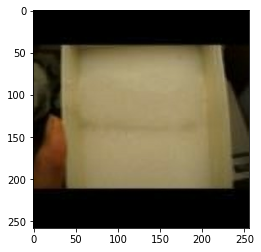

In [8]:
diffusion_hyper_resolution(sample_image, autoencoder_high)

Further experiments and metrics

In [74]:
def GAN_denoiser_train(x_1, x_2, gen, disc, batch_size, optimizer):
    with tf.GradientTape(persistent = True) as tape:
        
        random_t = tf.random.uniform([x.shape[0]],minval=1,maxval=250, dtype=tf.int32)
        float_random_t = tf.cast(random_t, tf.float64)
        stddevs = tf.map_fn(lambda l: prep_schedule[tf.cast(l,tf.int32)],float_random_t)

        actual_noises = tf.random.normal(x.shape, dtype=tf.float64)
        actual_noises = tf.transpose(tf.transpose(actual_noises)*stddevs)
        noisy_images = x_2 +actual_noises    
        #alternative version trains for one epoch the discriminator using loss_1
        #and for one epoch trains generator using loss_2 and loss_3
        loss_1 = tf.keras.losses.BinaryCrossentropy()(disc(x_1),tf.zeros([batch_size,1], dtype = tf.float64))
        loss_2 = tf.keras.losses.BinaryCrossentropy()(disc(gen((x_1,x_2))), tf.ones([batch_size,1], dtype = tf.float64))
        loss_3 = tf.keras.losses.MeanSquaredError()\
        (x_1,\
         gen((gen((x_1, x_2)), tf.image.resize_with_pad(x_high,256,256))))
        total_loss = loss_1 + loss_2 + (c_lambda * loss_3)

    gen_grads = tape.gradient(total_loss, gen.trainable_variables)
    
    disc_grads = tape.gradient(total_loss, disc.trainable_variables)

    optimizer.apply_gradients(zip(gen_grads, gen.trainable_variables))
    optimizer.apply_gradients(zip(disc_grads, disc.trainable_variables))

    del tape

    return total_loss
    

In [75]:
#train the GAN for denoising
#for i in range(n_epochs):
#  batch_count = 0
#  start = time.time()
#  for batch in GAN_dataset.shuffle(1000).batch(batch_size):
#    loss_history.append(GAN_diffusion_train(batch[0], batch[0] ,den_generator, den_discriminator,batch_size,opt))
#    batch_count +=1
#    if batch_count % 10 == 0:
#      #print("\r", end = '', flush = True)
#      print(batch_count)
#    #print('')
#  print(time.time()-start)
#  np_history = np.asarray(loss_history)
#  mean = np.mean(np_history)
#  print(mean)
#  epoch_loss_history.append(mean)
#  loss_history = []

In [76]:
#disc_den_x = layers.Conv2D(32,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_input)
#disc_den_x = layers.Conv2D(32,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_den_x)
#disc_den_x = layers.MaxPool2D()(disc_den_x)
#disc_den_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_den_x)
#disc_den_x = layers.Conv2D(64,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_den_x)
#disc_den_x = layers.Conv2D(1,3, padding = 'same', dtype = tf.float64, activation = 'relu')(disc_den_x)
#disc_den_x = layers.Flatten()(disc_x)
#disc_den_x = layers.Dense(1, activation = 'sigmoid')(disc_x)
#disc_den = Model(inputs=disc_input, outputs=disc_den_x)

In [77]:
#high_input_1 = layers.Input(shape=(256,256,3), dtype = tf.float64)
#high_input_2 = layers.Input(shape=(256,256,3), dtype = tf.float64)
#down_x_0 =layers.Conv2D(8,1, padding = 'same', dtype = tf.float64, activation = 'relu')(high_input)
#down_x_1 = DownBlock(16)(down_x_0)#128
#down_x_2=  DownBlock(32)(down_x_1)#64
#down_x_3=  DownBlock(512)(down_x_2)#32
#low_res_0 = layers.Conv2D(16,1, padding = 'same', dtype = tf.float64, activation = 'relu')(low_input)
#low_res_1 = DownBlock(32)(low_res_0)#64
#low_res_2=  DownBlock(512)(low_res_1)#32
#low_res_3=  DownBlock(512)(low_res_2)#32
#up_x_3 = UpBlock(256)(down_x_3, down_x_3,low_res_3)#32, 32, 32
#up_x_2 = UpBlock(16)(down_x_2, down_x_2,low_res_2)#64, 64, 64
#up_x_1 = UpBlock(8)(down_x_1, up_x_2,low_res_1)#128,128,128
#up_x_0 = MidBlock(4)(down_x_0, up_x_1,low_res_0)#256,256,256
#final_x = layers.Conv2D(3,1, padding = 'same', dtype = tf.float64, activation = 'relu')(up_x_0)
#generator = Model(inputs=(high_input, low_input), outputs=final_x)

In [79]:
#this was copied from here https://machinelearningmastery.com/how-to-implement-the-frechet-inception-distance-fid-from-scratch/
#it is the only part of this notebook that is taken from somewhere else
# example of calculating the frechet inception distance in Keras
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy import asarray
from numpy.random import randint
from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.datasets.mnist import load_data
from skimage.transform import resize
 
# scale an array of images to a new size
def scale_images(images, new_shape):
	images_list = list()
	for image in images:
		# resize with nearest neighbor interpolation
		new_image = resize(image, new_shape, 0)
		# store
		images_list.append(new_image)
	return asarray(images_list)
 
# calculate frechet inception distance
def calculate_fid(model, images1, images2):
	# calculate activations
	act1 = model.predict(images1)
	act2 = model.predict(images2)
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# prepare the inception v3 model
model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
# define two fake collections of images
images1 = randint(0, 255, 10*32*32*3)
images1 = images1.reshape((10,32,32,3))
images2 = randint(0, 255, 10*32*32*3)
images2 = images2.reshape((10,32,32,3))
print('Prepared', images1.shape, images2.shape)
# convert integer to floating point values
images1 = images1.astype('float32')
images2 = images2.astype('float32')
# resize images
images1 = scale_images(images1, (299,299,3))
images2 = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
images1 = preprocess_input(images1)
images2 = preprocess_input(images2)
# fid between images1 and images1
fid = calculate_fid(model, images1, images1)
print('FID (same): %.3f' % fid)
# fid between images1 and images2
fid = calculate_fid(model, images1, images2)
print('FID (different): %.3f' % fid)

87910968/87910968 [==============================] - 0s 0us/step
Prepared (10, 32, 32, 3) (10, 32, 32, 3)
Scaled (10, 299, 299, 3) (10, 299, 299, 3)
1/1 [==============================] - 0s 34ms/step
FID (same): -0.000
1/1 [==============================] - 0s 37ms/step
FID (different): 44.342


In [80]:
#like this is possible to prepare any image to be preprecessed to calculate the fid
prep_sample_image = sample_image
prep_sample_image = tf.image.resize_with_pad(prep_sample_image,299,299)
prep_sample_image = tf.reshape(prep_sample_image,[1,299,299,3])
prep_sample_image = prep_sample_image.numpy()
prep_sample_image = images1.astype('float32')
# resize images
prep_sample_image = scale_images(images1, (299,299,3))
prep_sample_image = scale_images(images2, (299,299,3))
print('Scaled', images1.shape, images2.shape)
# pre-process images
prep_sample_image = preprocess_input(images1)
prep_sample_image = preprocess_input(images2)


Scaled (10, 299, 299, 3) (10, 299, 299, 3)


In [81]:
calculate_fid(model, prep_sample_image, prep_sample_image)

1/1 [==============================] - 0s 33ms/step


-1.4179248197299022e-06